In [1]:
from ipynb.fs.full.arl_libq import *

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

# GBS Experiment

In [3]:
def recover_fock_state(i, m, cutoff):
    state = []
    for _ in range(m):
        state.append(i % cutoff)
        i //= cutoff
    return tuple(reversed(state))

In [4]:
def qm_gbs(
    U, 
    r=1, 
    cutoff=10
):
    '''Simulates Quantum Mechanical predictions of detection event likelyhoods
    resulting from passing squeezed states through the provided unitary.
    Returns map (detection_event -> probability).
    
    U : m x m matrix
        = unitary to be applied.'''

    m = U.shape[0]
    gbs = sf.Program(m)

    with gbs.context as q:
        # prepare the input squeezed states
        S = Sgate(r)
        for i in range(m):
            S | q[i]

        # linear interferometer
        Interferometer(U) | q
        
        # measure in Fock basis
        for i in range(m):
            MeasureFock() | q[i]
        
    eng = sf.Engine(backend="gaussian")
    result = eng.run(gbs)
    
    # Simple alternative:
    # result = eng.run(gbs, shots=1000)
    # return = Counter(result.samples > 0)
        
    state = result.state
    probs = state.all_fock_probs(cutoff=cutoff)
    qm_distr = defaultdict(lambda: 0)
    for i,p in enumerate(np.reshape(probs, cutoff**m)): # warning: run-time might blow up
        fock_outcome = recover_fock_state(i, m, cutoff)
        det_event = tuple([(1 if photon_num > 0 else 0) for photon_num in fock_outcome])
        qm_distr[det_event] += p
            
    # Using the walrus may let you get this distribution more directly using the torontonian
    # See: https://the-walrus.readthedocs.io/en/latest/_modules/thewalrus/samples.html#generate_torontonian_sample
    
    return qm_distr

In [5]:
def stoch_gbs(
    U, 
    r=1, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    '''Simulates Stochastic Mechanical predictions of detection event likelyhoods
    resulting from applying provided unitary to squeezed vacuum states.
    Returns map (detection_event -> probability).
    
    U : m x m matrix
        = unitary to be applied.
    r : float
        = squeezing strength.
    out_gamma : float
        = measurement threshold for output detectors.
    N : int
        = number of samples.'''
    
    m = U.shape[0]
    
    squeezed_states = np.concatenate([squeezed_zpf(N, r=r) for i in range(m)])
    dets = threshold_detector(squeezed_states, out_gamma)
    
    stoch_distr = defaultdict(lambda: 0)
    
    counts = Counter(map(tuple, dets.astype(int).T))
    stoch_normalization = 0
    for det_event in counts.keys():
        stoch_distr[det_event] = counts[det_event]
        stoch_normalization += counts[det_event]
    if stoch_normalization != 0:
        for det_event in stoch_distr:
            stoch_distr[det_event] /= stoch_normalization
                
    return stoch_distr

In [6]:
def gbs(
    m=None,
    U=None, 
    r=1,
    cutoff=10, 
    out_gamma=DEFAULT_MEAS_THRESH,
    N=1000000
):
    '''Gaussian Boson Sampling (GBS) experiment.
    Defaults to applying Haar-Random Unitary.
    Converts Fock states to 0/1 detection events.'''
        
    if m is None:
        if U is None:
            raise ValueError('Either unitary or number of modes must be specified.')
        m = U.shape[0]
            
    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    qm_distr = qm_gbs(U, r, cutoff)
    stoch_distr = stoch_gbs(U, r, out_gamma, N)

    return qm_distr, stoch_distr

In [7]:
# hardcodes 3 modes
def optimizable_gbs(x, m=3, U=None, cutoff=10, N=100000, shots=3, dist_func=DEFAULT_DIST_FUNC):
    running_tot = 0
    for i in range(shots):
        qm_distr, stoch_distr = gbs( 
            m=m,
            U=U,
            r=x[0], 
            cutoff=cutoff,
            out_gamma=x[1], 
            N=N
        )
        running_tot += dist_func(*distr_dicts_to_arrays(qm_distr, stoch_distr))
    return running_tot / shots

## GBS Tests

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


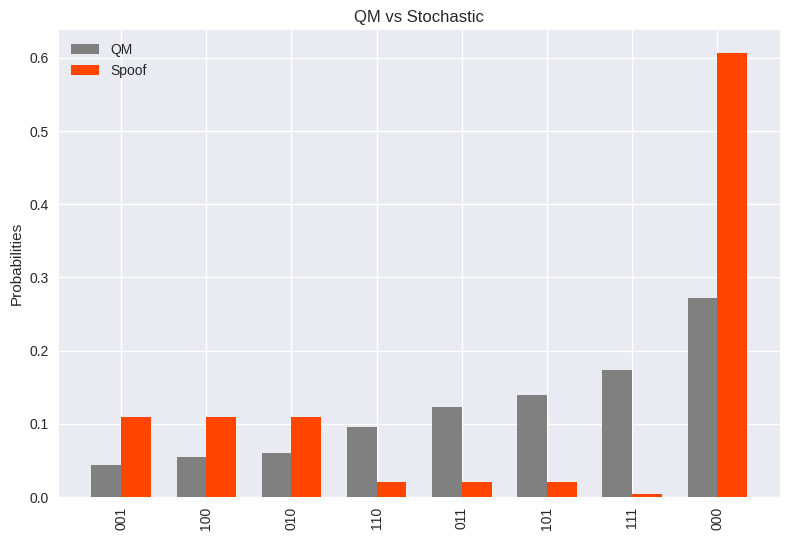

Trace Distance: 0.4873334471431867
Hellinger Distance: 0.41916705178953756
Chi-Square Test Statistic: 0.0
Chi-Square p-value: 0.0



In [8]:
analyze_distr(*gbs(3), N=1000000)

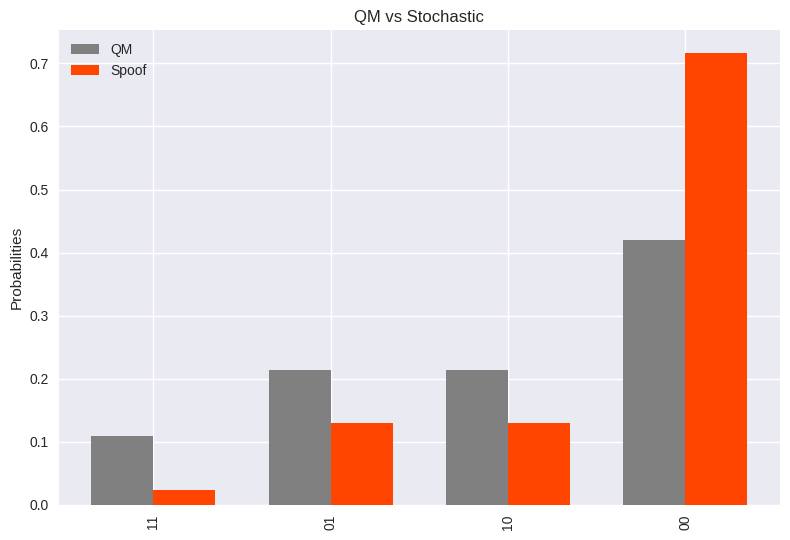

Trace Distance: 0.27429354016965396
Hellinger Distance: 0.21336571967231346
Chi-Square Test Statistic: 0.0
Chi-Square p-value: 0.0



In [9]:
# Basic Hadamard
analyze_distr(*gbs(U=hadamard), N=1000000)

### Haar-Random Unitary

In [10]:
x0 = [1, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_gbs, x0, method='Nelder-Mead', tol=1e-2)
res.x

array([1.17070307, 0.92901107])

In [11]:
print(optimizable_gbs(res.x))

0.26414007237242604


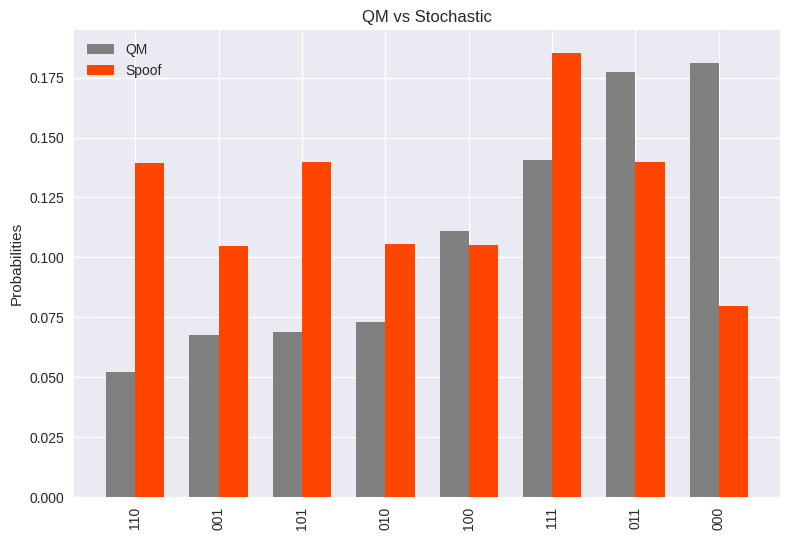

Trace Distance: 0.20868453959732625
Hellinger Distance: 0.18217408824165077
Chi-Square Test Statistic: 0.0
Chi-Square p-value: 0.0



In [12]:
analyze_distr(*gbs(
    3, 
    r=res.x[0], 
    out_gamma=res.x[1], 
    N=1000000
), N=1000000)

In [13]:
# past trace distance optimizations
print(optimizable_gbs([1.02929687, 1.91132578]))

0.4271820867982668


### Basic Hadamard

In [14]:
x0 = [1, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_gbs, x0, 
               args=(2, hadamard, 10, 100000, 3), 
               method='Nelder-Mead', tol=1e-2)
res.x

array([0.67526069, 1.31058749])

In [15]:
print(optimizable_gbs(res.x))

0.18510662481212184


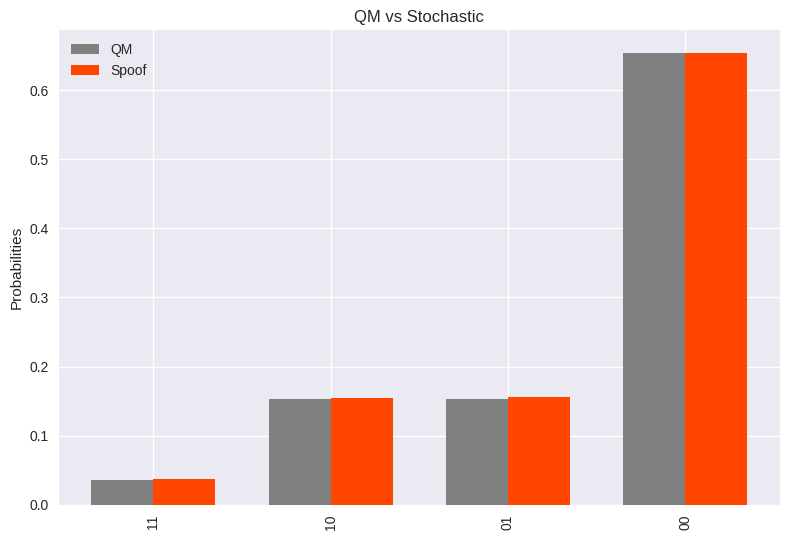

Trace Distance: 0.0015438563263624992
Hellinger Distance: 0.001980015753923028
Chi-Square Test Statistic: 4.011704771756823e-05
Chi-Square p-value: 4.011704771756823e-05



In [16]:
analyze_distr(*gbs(
    U=hadamard, 
    r=res.x[0], 
    out_gamma=res.x[1], 
    N=1000000
), N=1000000)

In [17]:
# past trace distance optimizations
print(optimizable_gbs([0.58431614, 1.3241543]))

0.19315803646984445
